In [16]:
%load_ext autoreload
%autoreload 2
from CNN_analysis_helper import get_FASHION_MNIST_data
from MNIST_helper import plot_numbers
from keras.callbacks import ModelCheckpoint 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import initializers
from keras.utils import to_categorical
from fnn_helper import PlotLosses
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Progreso Fashion MNIST

## Dataset

In [19]:
folder = '/Users/julianganzabal/.kaggle/competitions/fashion-mnist-itba-lab-ml/'
x_test = np.load(folder+'test_images.npy').reshape(x_test_.shape + (1,))
y_test = to_categorical(np.loadtxt('test_labels.csv', delimiter=',', skiprows=1)[:,0])

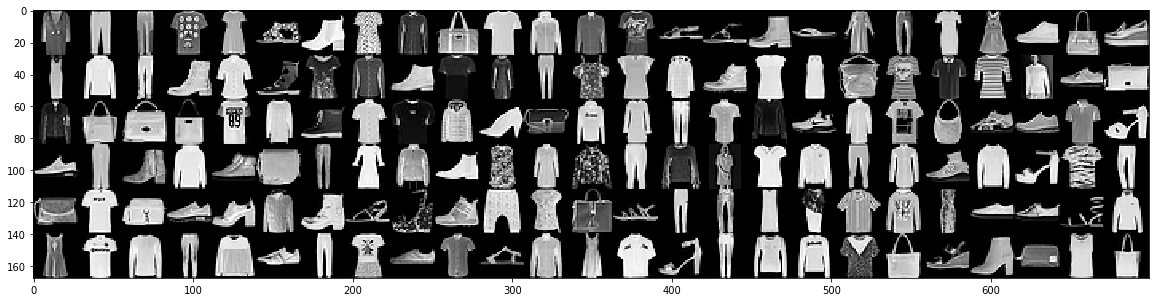

In [6]:
folder = '/Users/julianganzabal/.kaggle/competitions/fashion-mnist-itba-lab-ml/'
x_train, x_valid, y_train_categorical, y_val_categorical = get_FASHION_MNIST_data(folder)
plot_numbers(x_train.reshape(-1,28,28),range(150), columns=25, figsize=(20, 20))

## Preprocesamiento

- Limpiar datos
- Normalizar
- Reducción de parametros
- Transformación

## Antes de empezar a entrenar

- ¿Cual es la metrica que voy a utilizar para medir la performance del modelo?
- ¿Cual será la función de costo que voy a minimizar para entrenar el modelo?
- ¿Que arquitectura voy a utilizar?

## Nunca descartar un modelo simple
Nos da una cota inferior para modelos mas complejos

### Regresión logistica

In [30]:
output_size = 10
default_initializer = initializers.normal(mean=0, stddev=0.001)
model_logistic = Sequential()
model_logistic.add(Flatten(input_shape=x_train.shape[1:]))
model_logistic.add(Dense(output_size, kernel_initializer=default_initializer, name='Salida'))
model_logistic.add(Activation('softmax'))
model_logistic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 784)               0         
_________________________________________________________________
Salida (Dense)               (None, 10)                7850      
_________________________________________________________________
activation_21 (Activation)   (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


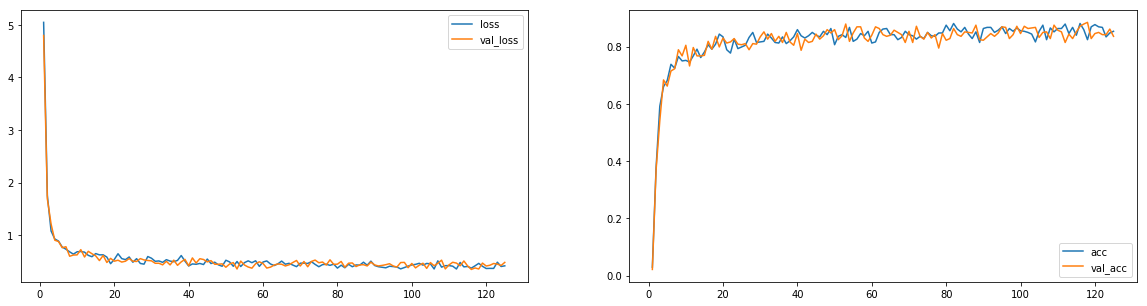

Epoch 00025: val_loss did not improve
48000/48000 [==============================] - 2s 40us/step - loss: 0.4141 - acc: 0.8566 - val_loss: 0.4348 - val_acc: 0.8449


In [31]:
lr = 0.00001
optim = optimizers.adam(lr=lr)
batch_size = 512
plot_losses = PlotLosses(plot_interval=1, 
                         evaluate_interval=20, 
                         val_samples=batch_size,
                         x_val=x_valid,
                         y_val_categorical=y_val_categorical)
checkpointer = ModelCheckpoint(filepath='model_logistic.mnist.hdf5', verbose=1, save_best_only=True)
model_logistic.compile(loss = 'categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
model_logistic.fit(x_train, 
                       y_train_categorical,
                       epochs=25, batch_size=batch_size, 
                       verbose=1, 
                       validation_data = (x_valid, y_val_categorical),
                       callbacks=[plot_losses, checkpointer],
                      )

In [32]:
print(model_logistic.evaluate(x_train, y_train_categorical))
print(model_logistic.evaluate(x_valid, y_val_categorical))

48000/48000 [==============================] - 3s 55us/step
[0.41912407543261848, 0.8528958333333333]
12000/12000 [==============================] - 1s 52us/step
[0.43477625791231789, 0.84491666666666665]


## Luego de las primeras corridas
- Cual es la cota superior de performance (Bayes error)
- Human performance
- Train performance

In [63]:
default_initializer = initializers.normal(mean=0, stddev=0.001)
model_hidden_1 = Sequential()
model_hidden_1.add(Flatten(input_shape=x_train.shape[1:]))
model_hidden_1.add(BatchNormalization())
model_hidden_1.add(Dense(800, kernel_initializer=default_initializer, name='Intermedia_1'))
model_hidden_1.add(BatchNormalization())
model_hidden_1.add(Activation('relu'))
model_hidden_1.add(Dense(800, kernel_initializer=default_initializer, name='Intermedia_2'))
model_hidden_1.add(BatchNormalization())
model_hidden_1.add(Activation('relu'))
model_hidden_1.add(Dense(800, kernel_initializer=default_initializer, name='Intermedia_3'))
model_hidden_1.add(BatchNormalization())
model_hidden_1.add(Activation('relu'))
model_hidden_1.add(Dense(800, kernel_initializer=default_initializer, name='Intermedia_4'))
model_hidden_1.add(BatchNormalization())
model_hidden_1.add(Activation('relu'))
model_hidden_1.add(Dense(800, kernel_initializer=default_initializer, name='Intermedia_5'))
model_hidden_1.add(BatchNormalization())
model_hidden_1.add(Activation('relu'))
model_hidden_1.add(Dense(output_size, kernel_initializer=default_initializer, name='Salida'))
model_hidden_1.add(Activation('softmax'))
model_hidden_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_26 (Flatten)         (None, 784)               0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 784)               3136      
_________________________________________________________________
Intermedia_1 (Dense)         (None, 800)               628000    
_________________________________________________________________
batch_normalization_67 (Batc (None, 800)               3200      
_________________________________________________________________
activation_97 (Activation)   (None, 800)               0         
_________________________________________________________________
Intermedia_2 (Dense)         (None, 800)               640800    
_________________________________________________________________
batch_normalization_68 (Batc (None, 800)               3200      
__________

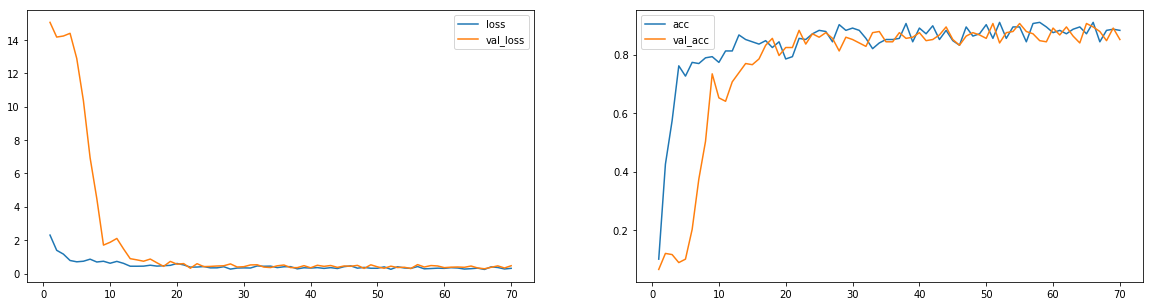

Epoch 00007: val_acc improved from 0.87658 to 0.88433, saving model to model_hidden_1.mnist.hdf5
48000/48000 [==============================] - 51s 1ms/step - loss: 0.3033 - acc: 0.8897 - val_loss: 0.3464 - val_acc: 0.8843
Epoch 8/50
17664/48000 [==========>...................] - ETA: 30s - loss: 0.2793 - acc: 0.8963

In [ ]:
lr = 0.1
optim = optimizers.adam(lr=lr, decay=0.0001)
batch_size = 256
plot_losses = PlotLosses(plot_interval=1, 
                         evaluate_interval=20, 
                         val_samples=batch_size,
                         x_val=x_valid,
                         y_val_categorical=y_val_categorical)
checkpointer = ModelCheckpoint(filepath='model_hidden_1.mnist.hdf5', verbose=1, save_best_only=True, monitor='val_acc')
model_hidden_1.compile(loss = 'categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
model_hidden_1.fit(x_train, 
                       y_train_categorical,
                       epochs=50, batch_size=batch_size, 
                       verbose=1, 
                       validation_data = (x_valid, y_val_categorical),
                       callbacks=[plot_losses, checkpointer],
                      )

In [26]:
print(model_hidden_1.evaluate(x_train, y_train_categorical))
print(model_hidden_1.evaluate(x_valid, y_val_categorical))
print(model_hidden_1.evaluate(x_test, y_test))

48000/48000 [==============================] - 25s 527us/step
[0.048302319634618472, 0.98281249999999998]
12000/12000 [==============================] - 7s 553us/step
[0.48359679296364388, 0.89291666666666669]
10000/10000 [==============================] - 5s 530us/step
[0.55748464944958687, 0.88039999999999996]


In [27]:
model_hidden_1.load_weights('model_hidden_1.mnist.hdf5')
print(model_hidden_do.evaluate(x_train, y_train_categorical))
print(model_hidden_do.evaluate(x_valid, y_val_categorical))
print(model_hidden_do.evaluate(x_test, y_test))

48000/48000 [==============================] - 24s 492us/step
[0.14730825861605504, 0.94508333333333339]
12000/12000 [==============================] - 6s 465us/step
[0.27965685928364598, 0.90258333333333329]
10000/10000 [==============================] - 5s 471us/step
[0.31598052335977556, 0.89080000000000004]


## Tenemos overfiting?

In [28]:
output_size = 10
default_initializer = initializers.normal(mean=0, stddev=0.001)
model_hidden_do = Sequential()
model_hidden_do.add(Flatten(input_shape=x_train.shape[1:]))
model_hidden_do.add(BatchNormalization())
model_hidden_do.add(Dense(784*2, kernel_initializer=default_initializer, name='Intermedia_1'))
model_hidden_do.add(BatchNormalization())
model_hidden_do.add(Activation('relu'))
model_hidden_do.add(Dropout(0.5))
model_hidden_do.add(Dense(784*2, kernel_initializer=default_initializer, name='Intermedia_2'))
model_hidden_do.add(BatchNormalization())
model_hidden_do.add(Activation('relu'))
model_hidden_do.add(Dropout(0.5))
model_hidden_do.add(Dense(output_size, kernel_initializer=default_initializer, name='Salida'))
model_hidden_do.add(Activation('softmax'))
model_hidden_do.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 784)               3136      
_________________________________________________________________
Intermedia_1 (Dense)         (None, 1568)              1230880   
_________________________________________________________________
batch_normalization_23 (Batc (None, 1568)              6272      
_________________________________________________________________
activation_21 (Activation)   (None, 1568)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1568)              0         
_________________________________________________________________
Intermedia_2 (Dense)         (None, 1568)              2460192   
__________

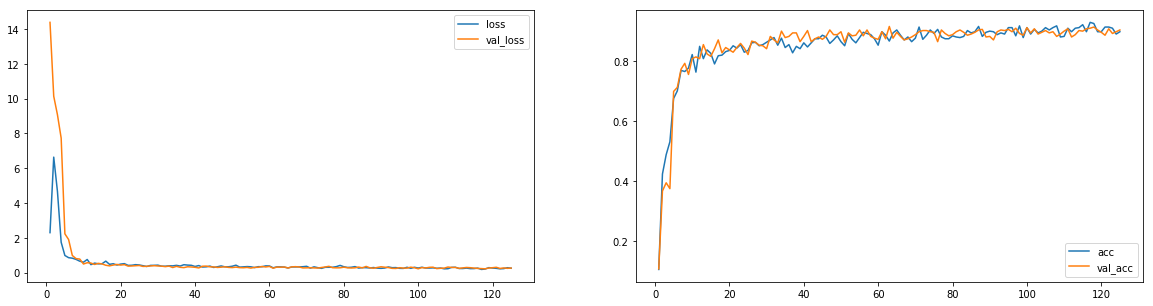

Epoch 00025: val_acc did not improve
48000/48000 [==============================] - 47s 972us/step - loss: 0.2534 - acc: 0.9061 - val_loss: 0.2854 - val_acc: 0.8969


In [29]:
lr = 0.05
optimizers.adam(lr=lr, decay=0.001)
batch_size = 512
plot_losses = PlotLosses(plot_interval=1, 
                         evaluate_interval=20, 
                         val_samples=batch_size,
                         x_val=x_valid,
                         y_val_categorical=y_val_categorical)
checkpointer = ModelCheckpoint(filepath='model_hidden_do.mnist.hdf5', verbose=1, save_best_only=True, monitor='val_acc')
model_hidden_do.compile(loss = 'categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
model_hidden_do.fit(x_train, 
                       y_train_categorical,
                       epochs=25, batch_size=batch_size, 
                       verbose=1, 
                       validation_data = (x_valid, y_val_categorical),
                       callbacks=[plot_losses, checkpointer],
                      )

In [30]:
print(model_hidden_do.evaluate(x_train, y_train_categorical))
print(model_hidden_do.evaluate(x_valid, y_val_categorical))
print(model_hidden_do.evaluate(x_test, y_test))

48000/48000 [==============================] - 22s 457us/step
[0.17636744953816136, 0.93152083333333335]
12000/12000 [==============================] - 6s 503us/step
[0.2853749246050914, 0.8969166666666667]
10000/10000 [==============================] - 4s 435us/step
[0.31943382679224014, 0.88829999999999998]


In [31]:
model_hidden_do.load_weights('model_hidden_do.mnist.hdf5')
print(model_hidden_do.evaluate(x_train, y_train_categorical))
print(model_hidden_do.evaluate(x_valid, y_val_categorical))
print(model_hidden_do.evaluate(x_test, y_test))

48000/48000 [==============================] - 20s 418us/step
[0.18475010641291736, 0.92906250000000001]
12000/12000 [==============================] - 5s 414us/step
[0.28709609104196232, 0.89766666666666661]
10000/10000 [==============================] - 4s 426us/step
[0.31909156851768494, 0.88870000000000005]
